In [1]:
from pathlib import Path
#define 3 folders
BASE = Path(".").resolve()
DATA = BASE / "data" #input video and dataset
MODELS = BASE / "models"# for the trained yolo model
OUT = BASE / "outputs"#where to store the result

OUT.mkdir(exist_ok=True, parents=True)
MODELS.mkdir(exist_ok=True, parents=True)

VIDEO_IN  = DATA / "input.mp4"
VIDEO_OUT = OUT / "video_annotato.mp4"
CSV_OUT   = OUT / "log_rilevazioni.csv"

print("BASE:", BASE)
print("DATA esiste?", DATA.exists(), "| MODELS?", MODELS.exists(), "| OUTPUTS?", OUT.exists())
print("Video atteso:", VIDEO_IN, "| esiste?", VIDEO_IN.exists())


BASE: /Users/francescofaustinogreco/Desktop/targa_lab 2
DATA esiste? True | MODELS? True | OUTPUTS? True
Video atteso: /Users/francescofaustinogreco/Desktop/targa_lab 2/data/input.mp4 | esiste? True


In [2]:
#install and check libraries 
import sys, subprocess

def ensure(pkg, spec=None):
    try:
        __import__(pkg)
        print(f"✓ {pkg} già presente")
    except Exception:
        to_install = spec or pkg
        print(f"→ installo {to_install} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", to_install])
        __import__(pkg)
        print(f"✓ {pkg} installato")

ensure("ultralytics", "ultralytics==8.3.0")  # for the YOLO model
ensure("cv2", "opencv-python")               # to process images and video
ensure("easyocr", "easyocr")                 # OCR for text recognition 

print("Librerie pronte ")


✓ ultralytics già presente
✓ cv2 già presente
✓ easyocr già presente
Librerie pronte 


In [3]:
#check the video before starting 
import cv2

cap = cv2.VideoCapture(str(VIDEO_IN))
if not cap.isOpened():
    raise RuntimeError("Non riesco ad aprire data/input.mp4 (controlla il file).")

ok, frame = cap.read()
cap.release()

print("Frame letto?", ok)
if ok:
    print("Dimensioni frame:", frame.shape)


Frame letto? True
Dimensioni frame: (720, 1280, 3)


In [4]:
from ultralytics import YOLO
import csv, time
import cv2

# object classes to detect using COCO dataset IDs: person=0, car=2, motorcycle=3, bus=5, truck=7
TRACKED_CLASSES = [0, 2, 3, 5, 7]
CONF_OBJ = 0.25
COCO_NAMES = {0:"person", 2:"car", 3:"motorcycle", 5:"bus", 7:"truck"}

print("Carico YOLO… (se serve scarica i pesi)")
obj_model = YOLO("yolo11n.pt")  # download yolo model 

#read the input video 
cap = cv2.VideoCapture(str(VIDEO_IN))
if not cap.isOpened():
    raise RuntimeError("Video non apribile")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#creating video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(VIDEO_OUT), fourcc, fps, (w, h))

# prepare the CSV log file to store result 
with open(CSV_OUT, "w", newline="", encoding="utf-8") as csv_f:
    csv_w = csv.writer(csv_f)
    csv_w.writerow(["frame","cat","conf","track_id","x1","y1","x2","y2"])
#reading frames and runnign YOLO
    frame_idx = 0
    t0 = time.time()

    try:
        while True:
            ok, frame = cap.read()
            if not ok:
                break
            frame_idx += 1

            res = obj_model.track(
                frame, persist=True, conf=CONF_OBJ, classes=TRACKED_CLASSES, verbose=False
            )

            if not res:
                writer.write(frame)
                continue

            r = res[0]
            boxes = r.boxes
            if boxes is None or len(boxes) == 0:
                writer.write(frame)
                continue


            #extracting object data and drawing boxes 
            for b in boxes:
                xyxy = b.xyxy.cpu().numpy().astype(int)[0]
                x1,y1,x2,y2 = [int(v) for v in xyxy]
                cls_id = int(b.cls.cpu().numpy()[0])
                conf   = float(b.conf.cpu().numpy()[0])
                tid    = int(b.id.cpu().numpy()[0]) if (b.id is not None) else -1
                cls_nm = COCO_NAMES.get(cls_id, f"c{cls_id}")

                # disegna riquadro e label
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
                label = f"{cls_nm}#{tid if tid!=-1 else '-'} {conf:.2f}"
                cv2.putText(frame, label, (x1, max(15,y1-7)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

                # save to CSV
                csv_w.writerow([frame_idx, cls_nm, f"{conf:.4f}", tid, x1,y1,x2,y2])

            writer.write(frame)

    finally:
        cap.release()
        writer.release()

print("Creati:", VIDEO_OUT, "e", CSV_OUT)


Carico YOLO… (se serve scarica i pesi)
Creati: /Users/francescofaustinogreco/Desktop/targa_lab 2/outputs/video_annotato.mp4 e /Users/francescofaustinogreco/Desktop/targa_lab 2/outputs/log_rilevazioni.csv


In [5]:
#put the video, check it, and choose the name of the result 
from pathlib import Path


VIDEO_FILE = "input2.mp4"   


VIDEO_IN = DATA / VIDEO_FILE
assert VIDEO_IN.exists(), f"Non trovo {VIDEO_IN}. Controlla il nome in data/."


VIDEO_TAG = Path(VIDEO_FILE).stem  
VIDEO_OUT = OUT / f"{VIDEO_TAG}_annotato.mp4"
CSV_OUT   = OUT / f"{VIDEO_TAG}_detections.csv"


VIDEO_OUT_LP = OUT / f"{VIDEO_TAG}_annotato_lp.mp4"
CSV_OUT_LP   = OUT / f"{VIDEO_TAG}_detections_lp.csv"

print("Userò questo input:", VIDEO_IN)
print("Salverò:", VIDEO_OUT)
print("        ", CSV_OUT)
print("        ", VIDEO_OUT_LP)
print("        ", CSV_OUT_LP)


Userò questo input: /Users/francescofaustinogreco/Desktop/targa_lab 2/data/input2.mp4
Salverò: /Users/francescofaustinogreco/Desktop/targa_lab 2/outputs/input2_annotato.mp4
         /Users/francescofaustinogreco/Desktop/targa_lab 2/outputs/input2_detections.csv
         /Users/francescofaustinogreco/Desktop/targa_lab 2/outputs/input2_annotato_lp.mp4
         /Users/francescofaustinogreco/Desktop/targa_lab 2/outputs/input2_detections_lp.csv


In [6]:
#install EasyOCR

import sys, subprocess

def _ensure(pkg, spec=None):
    try:
        __import__(pkg)
        print(f"✓ {pkg} ok")
    except Exception:
        to_install = spec or pkg
        print(f"→ installo {to_install} ... (attendi)")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", to_install])
        __import__(pkg)
        print(f"✓ {pkg} installato")


_ensure("easyocr", "easyocr")
import easyocr

#to switch to CPU mode 
try:
    ocr = easyocr.Reader(['en'], gpu=True)
    print("EasyOCR pronto (GPU)")
except Exception:
    ocr = easyocr.Reader(['en'], gpu=False)
    print("EasyOCR pronto (CPU)")


✓ easyocr ok
EasyOCR pronto (GPU)


In [7]:
#Plate recognition 
import cv2
import numpy as np

#cleans the text detected by OCR, keep letter and number
def normalize_plate_text(txt: str) -> str:
    keep = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    return "".join(ch for ch in txt.upper() if ch in keep)

#improve quality 
def enhance_for_ocr(img_bgr: np.ndarray) -> np.ndarray:
   
    if img_bgr is None or img_bgr.size == 0:
        return np.zeros((10,10), dtype=np.uint8)
    k = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=np.float32)
    sharp = cv2.filter2D(img_bgr, -1, k) #sharpening
    gray  = cv2.cvtColor(sharp, cv2.COLOR_BGR2GRAY) #garyscale
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))#equalize contrast
    eq    = clahe.apply(gray)
    th    = cv2.adaptiveThreshold(eq, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,#separate letter from the background 
                                  cv2.THRESH_BINARY, 11, 2)
    return th
#to find the plate inside a detected vehicle: apply filters, find contour that look like. aplate and select the biggest one and return the coordinate 
def find_plate_candidate_rect(veh_roi_bgr: np.ndarray):
    # cerca rettangolo tipo targa nella ROI del veicolo
    if veh_roi_bgr is None or veh_roi_bgr.size == 0:
        return None
    gry = cv2.cvtColor(veh_roi_bgr, cv2.COLOR_BGR2GRAY)
    gry = cv2.bilateralFilter(gry, 7, 75, 75)
    th  = cv2.adaptiveThreshold(gry, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY_INV, 21, 7)
    cnts,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:8]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if h == 0: 
            continue
        ratio = w / float(h)
        if 2.0 < ratio < 6.5 and w > 40 and h > 12:
            return (x, y, x+w, y+h)
    return None


In [ ]:
from ultralytics import YOLO
import csv, time, cv2
from pathlib import Path


try:
    VIDEO_OUT_LP, CSV_OUT_LP
except NameError:
    VIDEO_TAG = Path(str(VIDEO_IN)).stem
    VIDEO_OUT_LP = OUT / f"{VIDEO_TAG}_annotato_lp.mp4"
    CSV_OUT_LP   = OUT / f"{VIDEO_TAG}_detections_lp.csv"

try:
    obj_model
except NameError:
    obj_model = YOLO("yolo11n.pt")

TRACKED_CLASSES = [0, 2, 3, 5, 7]      # person/car/moto/bus/truck
COCO_NAMES = {0:"person", 2:"car", 3:"motorcycle", 5:"bus", 7:"truck"}
CONF_OBJ = 0.25

cap = cv2.VideoCapture(str(VIDEO_IN))
if not cap.isOpened():
    raise RuntimeError("Video non apribile")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer = cv2.VideoWriter(str(VIDEO_OUT_LP), cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

with open(CSV_OUT_LP, "w", newline="", encoding="utf-8") as csv_f:
    csv_w = csv.writer(csv_f)
    csv_w.writerow([
        "frame","cat","conf","track_id","x1","y1","x2","y2",
        "plate_text","plate_score","px1","py1","px2","py2"
    ])

    frame_idx = 0
    t0 = time.time()

    try:
        while True:
            ok, frame = cap.read()
            if not ok: break
            frame_idx += 1

            res = obj_model.track(frame, persist=True, conf=CONF_OBJ, classes=TRACKED_CLASSES, verbose=False)
            if not res:
                writer.write(frame); continue

            r = res[0]
            boxes = r.boxes
            if boxes is None or len(boxes) == 0:
                writer.write(frame); continue

            for b in boxes:
                xyxy = b.xyxy.cpu().numpy().astype(int)[0]
                x1,y1,x2,y2 = [int(v) for v in xyxy]
                cls_id = int(b.cls.cpu().numpy()[0])
                conf   = float(b.conf.cpu().numpy()[0])
                tid    = int(b.id.cpu().numpy()[0]) if (b.id is not None) else -1
                cls_nm = COCO_NAMES.get(cls_id, f"c{cls_id}")

                # disegna oggetto
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
                cv2.putText(frame, f"{cls_nm}#{tid if tid!=-1 else '-'} {conf:.2f}",
                            (x1, max(15,y1-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            (0,255,0), 1, cv2.LINE_AA)

                # default valori targa vuoti
                plate_txt, plate_scr = "", 0.0
                px1=py1=px2=py2=None

                # OCR solo sui veicoli
                if cls_id in (2,3,5,7):
                    vx1, vy1 = max(0,x1), max(0,y1)
                    vx2, vy2 = min(w-1,x2), min(h-1,y2)
                    veh_roi = frame[vy1:vy2, vx1:vx2]

                    cand = find_plate_candidate_rect(veh_roi)
                    if cand:
                        cx1,cy1,cx2,cy2 = cand
                        cx1 = max(0, min(cx1, veh_roi.shape[1]-1))
                        cx2 = max(0, min(cx2, veh_roi.shape[1]-1))
                        cy1 = max(0, min(cy1, veh_roi.shape[0]-1))
                        cy2 = max(0, min(cy2, veh_roi.shape[0]-1))

                        plate_roi = veh_roi[cy1:cy2, cx1:cx2].copy()

                        # ingrandisco se piccola 
                        if plate_roi.size:
                            ph, pw = plate_roi.shape[:2]
                            scale = 3.0 if min(ph,pw) < 60 else 2.0
                            plate_roi = cv2.resize(plate_roi, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

                        prep = enhance_for_ocr(plate_roi)
                        ocr_out = ocr.readtext(prep, detail=1, paragraph=False,
                                               allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
                        if ocr_out:
                            best_text, best_score = max(((t[1], t[2]) for t in ocr_out), key=lambda x: x[1])
                            plate_txt = normalize_plate_text(best_text)
                            plate_scr = float(best_score)

                            px1, py1 = vx1 + cx1, vy1 + cy1
                            px2, py2 = vx1 + cx2, vy1 + cy2
                            cv2.rectangle(frame, (px1,py1), (px2,py2), (0,255,255), 2)
                            if plate_txt:
                                cv2.putText(frame, f"{plate_txt} {plate_scr:.2f}",
                                            (px1, max(15,py1-7)), cv2.FONT_HERSHEY_SIMPLEX,
                                            0.55, (0,255,255), 2, cv2.LINE_AA)

                csv_w.writerow([
                    frame_idx, cls_nm, f"{conf:.4f}", tid, x1,y1,x2,y2,
                    plate_txt, f"{plate_scr:.4f}",
                    "" if px1 is None else px1,
                    "" if py1 is None else py1,
                    "" if px2 is None else px2,
                    "" if py2 is None else py2
                ])

            writer.write(frame)

    finally:
        cap.release()
        writer.release()

print("Creati:", VIDEO_OUT_LP, "e", CSV_OUT_LP)


In [9]:
from pathlib import Path
import glob

ROOT = Path("datasets/data_lp") 
for split in ["train","val","test"]:
    n = len(glob.glob(str((ROOT/split/"images" ).resolve()/"*")))
    m = len(glob.glob(str((ROOT/split/"labels").resolve()/"*.txt")))
    print(f"{split}: {n} immagini, {m} label")


train: 15 immagini, 15 label
val: 2 immagini, 2 label
test: 7 immagini, 7 label


In [10]:
from pathlib import Path

ROOT = Path("datasets/data_lp").resolve()  
yaml_path = ROOT / "data_lp.yaml"

train_dir = (ROOT / "train" / "images").resolve()
val_dir   = (ROOT / "val"   / "images").resolve()
test_dir  = (ROOT / "test"  / "images").resolve()

yaml_text = f"""train: {train_dir}
val: {val_dir}
test: {test_dir}

nc: 1
names: [license_plate]
"""

yaml_path.write_text(yaml_text, encoding="utf-8")
print(" YAML aggiornato:", yaml_path)
print("train:", train_dir)
print("val  :", val_dir)
print("test :", test_dir)



 YAML aggiornato: /Users/francescofaustinogreco/Desktop/targa_lab 2/datasets/data_lp/data_lp.yaml
train: /Users/francescofaustinogreco/Desktop/targa_lab 2/datasets/data_lp/train/images
val  : /Users/francescofaustinogreco/Desktop/targa_lab 2/datasets/data_lp/val/images
test : /Users/francescofaustinogreco/Desktop/targa_lab 2/datasets/data_lp/test/images


In [11]:
import glob, os
def count_imgs(p): return len(glob.glob(str(p/"*")))
print("train imgs:", count_imgs(train_dir))
print("val   imgs:", count_imgs(val_dir))
print("test  imgs:", count_imgs(test_dir))

assert os.path.isdir(train_dir) and os.path.isdir(val_dir) and os.path.isdir(test_dir), "Una delle cartelle non esiste"


train imgs: 15
val   imgs: 2
test  imgs: 7


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
results = model.train(
    data=str(yaml_path.resolve()),   # <— usa il percorso ASSOLUTO al yaml
    imgsz=640,
    epochs=80,
    batch=4,
    device="cpu",
    project="runs_lp",
    name="lp_train2"
)

print(" Training partito. Pesi in: runs_lp/lp_train2/weights/best.pt")


In [13]:
from pathlib import Path
print(list(Path("runs_lp").rglob("*.pt")))


[PosixPath('runs_lp/lp_train2/weights/last.pt'), PosixPath('runs_lp/lp_train2/weights/best.pt')]


In [ ]:
from ultralytics import YOLO
from pathlib import Path

LP_WEIGHTS = Path("runs_lp/lp_train23/weights/best.pt")  # <— quello giusto che hai trovato
lp_model = YOLO(str(LP_WEIGHTS))
print(" Modello targhe caricato:", LP_WEIGHTS)


In [ ]:
from ultralytics import YOLO
from pathlib import Path

# Percorso ai pesi migliori
LP_WEIGHTS = Path("runs_lp/lp_train23/weights/best.pt")

# Percorso al dataset di test
DATASET_YAML = "datasets/data_lp/data_lp.yaml"

# Carico il modello
lp_model = YOLO(str(LP_WEIGHTS))

# Valutazione sul set di test
results = lp_model.val(
    data=DATASET_YAML,
    split='test',       # usa le immagini del set di test
    imgsz=640,          # dimensione immagini per YOLO
    conf=0.25,          # soglia di confidenza
    iou=0.6,            # soglia IoU
    save_json=True,     # salva anche in formato COCO
    verbose=True        # mostra i dettagli
)

print("\nValutazione completata!")
print(results)


In [27]:
from ultralytics import YOLO
from pathlib import Path

LP_WEIGHTS = Path("runs_lp/lp_train23/weights/best.pt")
DATASET = Path("/Users/biancacocci/Downloads/targa_lab/datasets/data_lp")
TEST_IMGS = DATASET / "test/images"
OUT_DIR = Path("runs_lp/lp_test_pred")
OUT_DIR.mkdir(parents=True, exist_ok=True)

m = YOLO(str(LP_WEIGHTS))
res = m.predict(
    source=str(TEST_IMGS),
    imgsz=640,
    conf=0.25,
    iou=0.6,
    save=True,          # salva immagini annotate
    save_txt=True,      # salva .txt con box predette
    project=str(OUT_DIR),
    name="pred",
    exist_ok=True
)
print(" Predizioni salvate in:", OUT_DIR / "pred")



image 1/7 /Users/biancacocci/Downloads/targa_lab/datasets/data_lp/test/images/3824JLB.jpg: 640x480 1 license_plate, 233.1ms
image 2/7 /Users/biancacocci/Downloads/targa_lab/datasets/data_lp/test/images/3857JXJ.jpg: 640x384 1 license_plate, 231.2ms
image 3/7 /Users/biancacocci/Downloads/targa_lab/datasets/data_lp/test/images/4003GKC.jpg: 480x640 3 license_plates, 283.4ms
image 4/7 /Users/biancacocci/Downloads/targa_lab/datasets/data_lp/test/images/4022LXD.jpeg: 640x480 1 license_plate, 454.2ms
image 5/7 /Users/biancacocci/Downloads/targa_lab/datasets/data_lp/test/images/4193KRS.jpg: 640x384 1 license_plate, 453.3ms
image 6/7 /Users/biancacocci/Downloads/targa_lab/datasets/data_lp/test/images/4266KML.jpeg: 640x480 1 license_plate, 237.3ms
image 7/7 /Users/biancacocci/Downloads/targa_lab/datasets/data_lp/test/images/4280KSW.jpg: 640x384 1 license_plate, 619.9ms
Speed: 4.4ms preprocess, 358.9ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs_lp/lp_te

In [13]:
import pytesseract, shutil, sys, platform
print("Python:", sys.version)
print("mac:", platform.platform())
print("pytesseract:", pytesseract.__version__)

# prova a trovare l'eseguibile di tesseract
print("tesseract path (detected):", shutil.which("tesseract"))
print("tesseract version (via pytesseract):", pytesseract.get_tesseract_version())


Python: 3.9.5 (default, May 18 2021, 12:31:01) 
[Clang 10.0.0 ]
mac: macOS-10.16-x86_64-i386-64bit
pytesseract: 0.3.13
tesseract path (detected): /usr/local/bin/tesseract
tesseract version (via pytesseract): 5.5.1


In [17]:
%matplotlib inline


🧾 OCR: F3026J8


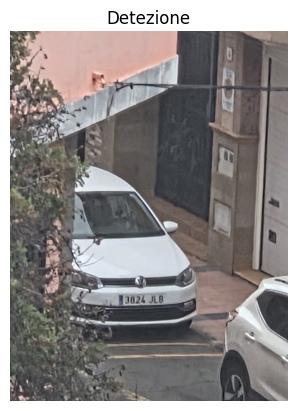

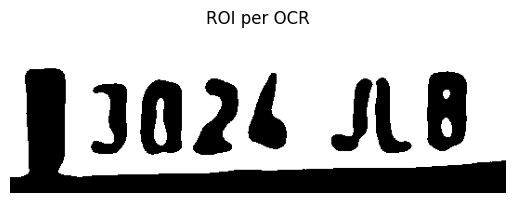

In [ ]:
# Trovare la targa dalla foto

from ultralytics import YOLO
import cv2, pytesseract
from pathlib import Path

img_path = Path("datasets/data_lp/test/images/3824JLB.jpg")
img = cv2.imread(str(img_path))

# 1) Detect targa
lp_model = YOLO("runs_lp/lp_train23/weights/best.pt")
pred = lp_model.predict(source=str(img_path), conf=0.25, verbose=False)[0]

if pred.boxes is None or len(pred.boxes)==0:
    raise RuntimeError("Nessuna targa trovata nell'immagine")

# prendo la bbox migliore
b = pred.boxes[0]
x1,y1,x2,y2 = map(int, b.xyxy[0].cpu().numpy())

# padding per non tagliare troppo stretto
H,W = img.shape[:2]
pad = 8
x1 = max(0, x1-pad); y1 = max(0, y1-pad)
x2 = min(W-1, x2+pad); y2 = min(H-1, y2+pad)

plate_roi = img[y1:y2, x1:x2]

# 2) Preprocessing leggero per OCR
gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 9, 75, 75)
gray = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
_, thr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# 3) OCR
cfg = "--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
text = pytesseract.image_to_string(thr, config=cfg).strip()
print("🧾 OCR:", text)

# mostra anteprime
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Detezione"); plt.axis("off"); plt.show()
plt.imshow(thr, cmap="gray"); plt.title("ROI per OCR"); plt.axis("off"); plt.show()





In [28]:
from ultralytics import YOLO
import cv2, pytesseract, re, csv
from pathlib import Path
import numpy as np
from difflib import SequenceMatcher

# PATH 
DATA = Path("datasets/data_lp")
TEST_IMGS = DATA/"test/images"
TEST_LBLS = DATA/"test/labels"
LP_WEIGHTS = Path("runs_lp/lp_train23/weights/best.pt") 

#  utility 
def yolo_txt_to_xyxy(lbl_path, img_w, img_h):
    """
    Ritorna la prima bbox GT in formato [x1,y1,x2,y2] (classe singola).
    File YOLO: cls cx cy w h (normalizzati 0..1)
    """
    if not lbl_path.exists():
        return None
    with open(lbl_path, "r") as f:
        line = f.readline().strip()
    if not line:
        return None
    _, cx, cy, w, h = map(float, line.split())
    x1 = int((cx - w/2) * img_w)
    y1 = int((cy - h/2) * img_h)
    x2 = int((cx + w/2) * img_w)
    y2 = int((cy + h/2) * img_h)
    return [max(0,x1), max(0,y1), min(img_w-1,x2), min(img_h-1,y2)]

def iou_xyxy(a, b):
    if a is None or b is None: return 0.0
    ax1,ay1,ax2,ay2 = a
    bx1,by1,bx2,by2 = b
    inter_x1, inter_y1 = max(ax1,bx1), max(ay1,by1)
    inter_x2, inter_y2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, inter_x2-inter_x1), max(0, inter_y2-inter_y1)
    inter = iw*ih
    area_a = max(0,ax2-ax1)*max(0,ay2-ay1)
    area_b = max(0,bx2-bx1)*max(0,by2-by1)
    union = area_a + area_b - inter + 1e-9
    return inter/union

def preprocess_for_ocr(roi_bgr):
    g = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.bilateralFilter(g, 9, 75, 75)
    g = cv2.resize(g, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    _, thr = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return thr

def ocr_text(img_gray_bin):
    cfg = "--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    t = pytesseract.image_to_string(img_gray_bin, config=cfg).strip()

    return re.sub(r"[^A-Z0-9]", "", t.upper())

def gt_text_from_filename(p: Path):
    # estrae stringa alfanumerica lunga ≥5 dal nome file (es. 3824JLB)
    m = re.search(r"([A-Za-z0-9]{5,})", p.stem)
    return m.group(1).upper() if m else ""

#  modello 
lp_model = YOLO(str(LP_WEIGHTS))

rows = []
det_ok = 0
ocr_exact = 0
ious = []

for img_path in sorted(TEST_IMGS.glob("*")):
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    # GT bbox e GT testo 
    gt_bbox = yolo_txt_to_xyxy(TEST_LBLS/(img_path.stem + ".txt"), w, h)
    gt_txt = gt_text_from_filename(img_path)

    # pred bbox 
    pred = lp_model.predict(source=str(img_path), conf=0.25, verbose=False)[0]
    if pred.boxes is None or len(pred.boxes) == 0:
        pred_bbox = None
        ocr = ""
        iou = 0.0
    else:
        best = pred.boxes[pred.boxes.conf.argmax()]
        x1,y1,x2,y2 = map(int, best.xyxy[0].cpu().numpy())
        pad = 8
        x1 = max(0, x1-pad); y1 = max(0, y1-pad)
        x2 = min(w-1, x2+pad); y2 = min(h-1, y2+pad)
        pred_bbox = [x1,y1,x2,y2]

        roi = img[y1:y2, x1:x2]
        thr = preprocess_for_ocr(roi)
        ocr = ocr_text(thr)
        iou = iou_xyxy(pred_bbox, gt_bbox)

    ious.append(iou)
    det_ok += int(iou >= 0.5)
    # confronto OCR con GT dal nome file 
    match = int(gt_txt != "" and ocr == gt_txt)
    ocr_exact += match

    rows.append({
        "file": img_path.name,
        "gt_text": gt_txt,
        "ocr_text": ocr,
        "gt_bbox": gt_bbox,
        "pred_bbox": pred_bbox,
        "IoU": round(iou, 3)
    })

#  salvataggio CSV + riepilogo 
out_csv = Path("outputs/test_lp_eval.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    wcsv = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    wcsv.writeheader()
    for r in rows: wcsv.writerow(r)

n = len(rows)
print(f" Immagini test: {n}")
print(f"Detection@0.50: {det_ok}/{n} = {det_ok/n:.2%}")
print(f"IoU medio: {np.mean(ious):.3f}")
if any(r['gt_text'] for r in rows):
    print(f" OCR exact match (dal nome file): {ocr_exact}/{n} = {ocr_exact/n:.2%}")
print(f"CSV salvato in: {out_csv}")


 Immagini test: 7
Detection@0.50: 6/7 = 85.71%
IoU medio: 0.646
 OCR exact match (dal nome file): 0/7 = 0.00%
CSV salvato in: outputs/test_lp_eval.csv


In [32]:
from pathlib import Path

BASE   = Path.home() / "Documents/targa_lab"
DATA   = BASE / "data"
OUT    = BASE / "outputs"


VIDEO_IN = DATA / "testvideo.mp4"


LP_WEIGHTS = Path("runs_lp/lp_train23/weights/best.pt")

print("Video:", VIDEO_IN, VIDEO_IN.exists())
print("Pesi LP:", LP_WEIGHTS, LP_WEIGHTS.exists())


Video: /Users/biancacocci/Documents/targa_lab/data/testvideo.mp4 True
Pesi LP: runs_lp/lp_train23/weights/best.pt True


In [ ]:
# Generazione video output

from ultralytics import YOLO
import cv2, csv, time
from pathlib import Path


VIDEO_OUT = OUT / "video_lp_annotato.mp4"
CSV_OUT = OUT / "video_lp_rilevazioni.csv"

lp_model = YOLO("runs_lp/lp_train23/weights/best.pt")
print("Modello targhe caricato correttamente")

cap = cv2.VideoCapture(str(VIDEO_IN))
if not cap.isOpened():
    raise RuntimeError(" Impossibile aprire il video")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter(str(VIDEO_OUT), cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

print(f"Analizzo: {VIDEO_IN.name}")
start = time.time()

#Analisi frame per frame 
with open(CSV_OUT, "w", newline="", encoding="utf-8") as f:
    writer_csv = csv.writer(f)
    writer_csv.writerow(["frame", "conf", "x1", "y1", "x2", "y2"])

    frame_idx = 0
    while True:
        ok, frame = cap.read()
        if not ok: break
        frame_idx += 1

        # Rilevazione targa
        res = lp_model.predict(frame, conf=0.25, verbose=False)
        boxes = res[0].boxes

        if boxes is not None and len(boxes) > 0:
            for b in boxes:
                x1, y1, x2, y2 = map(int, b.xyxy[0].cpu().numpy())
                conf = float(b.conf.cpu().numpy())
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
                cv2.putText(frame, f"{conf:.2f}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
                writer_csv.writerow([frame_idx, conf, x1, y1, x2, y2])

        writer.write(frame)

cap.release()
writer.release()
print(f"Video elaborato in {time.time() - start:.1f}s")
print("Salvati:")
print("video", VIDEO_OUT)
print("csv", CSV_OUT)


Modello targhe caricato correttamente
Analizzo: testvideo.mp4


/var/folders/fc/m7p3l26s0dlcnbdtzb1b_f9r0000gn/T/ipykernel_4453/251452.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(b.conf.cpu().numpy())


Video elaborato in 543.4s
Salvati:
video /Users/biancacocci/Documents/targa_lab/outputs/video_lp_annotato.mp4
csv /Users/biancacocci/Documents/targa_lab/outputs/video_lp_rilevazioni.csv
